# Shelter Animal Outcome Project

This notebook analyzes the Kaggle shelter animal dataset, builds a classification model, and predicts the outcome of each animal in the test dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline  
plt.style.use('ggplot')
from collections import Counter
from operator import itemgetter
import datetime
import sklearn
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

/Users/kalaivanikubendran/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load the dataset

In [54]:
shelter_train = pd.read_csv('train.csv')
shelter_test = pd.read_csv('test.csv')

In [55]:
shelter_train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2/12/14 18:22,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,10/13/13 12:44,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,1/31/15 12:28,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,7/11/14 19:09,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,11/15/13 12:52,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [56]:
shelter_train.describe().T

,count,unique,top,freq
AnimalID,26729,26729,A705677,1
Name,19038,6374,Max,136
DateTime,26729,22918,8/11/15 0:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


## Exploratory Analysis

Separate the dataset based on animal type to explore their species specific characteristics on the outcome type.

In [57]:
cat_train = shelter_train[shelter_train.AnimalType == "Cat"]
dog_train = shelter_train[shelter_train.AnimalType == 'Dog']

In [58]:
dog_train_grouped = dog_train.groupby(by=['OutcomeType'])['AnimalID'].count()
cat_train_grouped = cat_train.groupby(by=['OutcomeType'])['AnimalID'].count()

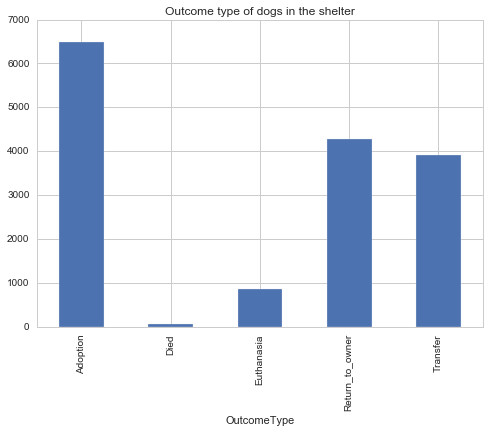

In [59]:
dog_train_grouped.plot(kind="bar", title="Outcome type of dogs in the shelter")
plt.show()

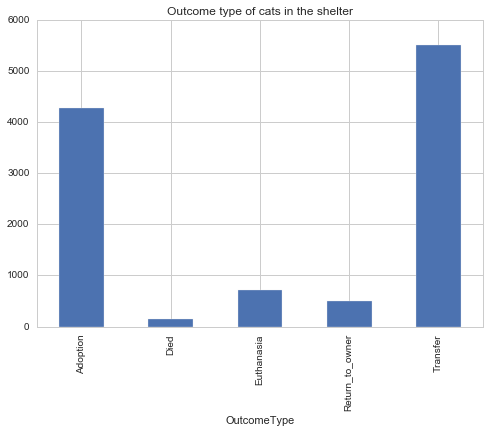

In [16]:
cat_train_grouped.plot(kind="bar", title="Outcome type of cats in the shelter")
plt.show()

We can see that depending on the animal type, the majority outcome can differ. Cats have higher probability to be transferred, while dogs have higher probability to be adopted.

### Few more exploratory analysis--by age, time of day, breed, color, breed

## Data Cleaning

Age of each animal is given as in character format in different units (months and years). We need to change this to a standardized format, preferably in numeric format so that model can use this as a dependent variable.

A function is written to separate 'AgeuponOutcome' column into two fields--the number and its unit. The second function converts the age to a common denominator, in this case, the age is represented in the unit of months for all the animals

In [60]:
def split_age(line):
    num, unit = line.split()
    return (num, unit)

def convert_ageunit_to_months(line):
    if (line == "year" or line == "years"):
        conversion = 12
    else:
        conversion = 1
        
    return conversion

In [61]:
shelter_train_na = shelter_train.drop(['Name', 'OutcomeSubtype'], axis=1)

shelter_train_na = shelter_train_na.dropna()

#shelter_train_na = shelter_train

In [62]:
a = shelter_train_na.AgeuponOutcome.map(split_age)

df=pd.DataFrame(a.tolist())
df.columns=['AgeNumber', 'AgeUnit']

df['Converted_ageunit'] = df.AgeUnit.apply(convert_ageunit_to_months) 
df['Age'] = pd.to_numeric(df['Converted_ageunit'] * pd.to_numeric(df['AgeNumber']))
shelterCleaned = pd.concat([shelter_train_na.reset_index(), df], axis=1)

In [10]:

shelterCleaned.head()

,index,AnimalID,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,AgeNumber,AgeUnit,Converted_ageunit,Age
0,0,A671945,2/12/14 18:22,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,year,12,12
1,1,A656520,10/13/13 12:44,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,year,12,12
2,2,A686464,1/31/15 12:28,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2,years,12,24
3,3,A683430,7/11/14 19:09,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,3,weeks,1,3
4,4,A667013,11/15/13 12:52,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2,years,12,24


## Coding for "Black Pet Syndrome"

In [63]:
shelterCleaned['isBlack'] = np.where(shelterCleaned['Color'].str.contains('Black'), 1, 0)
shelterCleaned['Intact'] = np.where(shelterCleaned['SexuponOutcome'].str.contains('Intact'), 1, 0)
shelterCleaned['Sex'] = np.where(shelterCleaned['SexuponOutcome'].str.contains('Male'), 1, 0)
shelterCleaned['DogOrCat'] = np.where(shelterCleaned['AnimalType'].str.contains('Dog'), 1, 0)
shelterCleaned['Target'] = np.where(shelterCleaned['OutcomeType'].str.contains('Adoption'), 1, 
                                   np.where(shelterCleaned['OutcomeType'].str.contains('Died'),2,
                                            np.where(shelterCleaned['OutcomeType'].str.contains('Euthanasia'),3,
                                                     np.where(shelterCleaned['OutcomeType'].str.contains('Return_to_owner'),4,5))))

In [64]:
shelterCleaned['Breed'] = shelterCleaned['Breed'].replace(to_replace='/', value=" ", regex=True)

In [65]:
import datetime
d = datetime.datetime.strptime("2/3/16 11:27", "%m/%d/%y %H:%M")

Next step is to code time of day and month details. Some months are prone for shelter adoption, such as, after Christmas.

In [66]:
shelterCleaned['Hour'] = shelterCleaned['DateTime'].map(lambda t: datetime.datetime.strptime(t, "%m/%d/%y %H:%M").hour)
shelterCleaned['Month'] = shelterCleaned['DateTime'].map(lambda t: datetime.datetime.strptime(t, "%m/%d/%y %H:%M").month)

In [67]:
shelterCleaned['Mix'] = np.where(shelterCleaned['Breed'].str.contains('Mix'), 1, 0)
shelterCleaned['isBullyBreed'] = np.where(shelterCleaned['Breed'].str.contains('Pit Bull'), 1, 0)


In [68]:
shelterCleanFinal = shelterCleaned[['Target', 'Age', 'DogOrCat', 'Intact', 'Sex', 'isBlack','Hour','Month', 'Mix', 'isBullyBreed']]

In [18]:
cat_trainCleaned = shelterCleaned[shelterCleaned.AnimalType == "Cat"]
dog_trainCleaned = shelterCleaned[shelterCleaned.AnimalType == 'Dog']

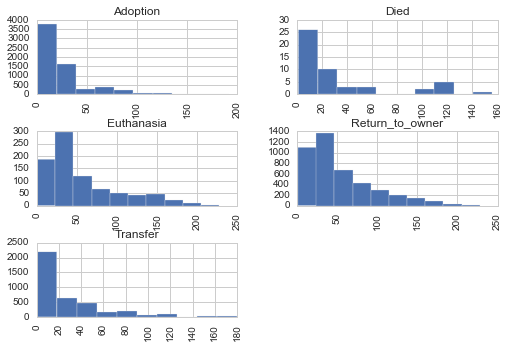

In [32]:

dog_trainCleaned.hist(by='OutcomeType', column='Age')
plt.show()

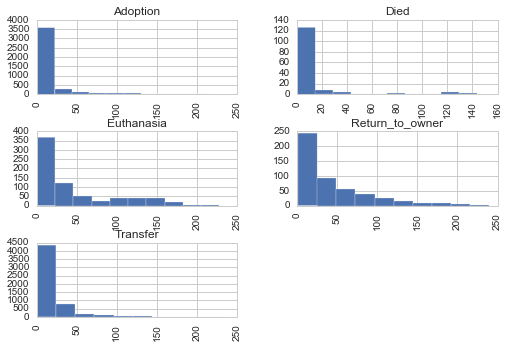

In [33]:
cat_trainCleaned.hist(by='OutcomeType',column = 'Age')
plt.show()

## Feature Engineering

Mix breeds are abundant in shelters. And there is a popular notion that purebred animals (more specifically dogs) are preferred over mix breeds. This section will use the 'Breed' data to create a decision column that decides if the animal is a mix or not.

In [34]:
dog_trainCleaned['Mix'] = np.where(dog_trainCleaned['Breed'].str.contains('Mix'), 1, 0)

/Users/kalaivanikubendran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [35]:
dog_trainCleaned['isBullyBreed'] = np.where(dog_trainCleaned['Breed'].str.contains('Pit Bull'), 1, 0)

/Users/kalaivanikubendran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


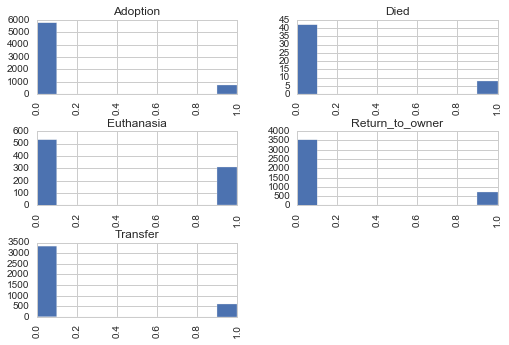

In [36]:
dog_trainCleaned.hist(by='OutcomeType', column='isBullyBreed')
plt.show()

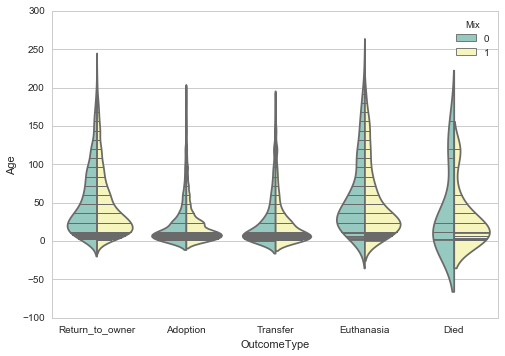

In [37]:
sns.violinplot(x="OutcomeType", y="Age", hue="Mix", data=dog_trainCleaned,
               split=True, inner="stick", palette="Set3");

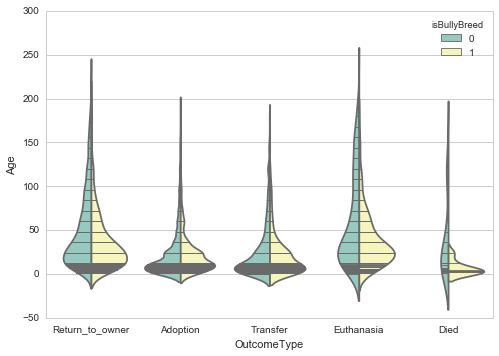

In [38]:
sns.violinplot(x="OutcomeType", y="Age", hue="isBullyBreed", data=dog_trainCleaned,
               split=True, inner="stick", palette="Set3");

## Model

In [90]:
from sklearn.cross_validation import train_test_split
train_data, eval_data = train_test_split(shelterCleanFinal, test_size = 0.3)

test_data, validation_data = train_test_split(eval_data, test_size = 0.5)


In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [92]:
forest = RandomForestClassifier(n_estimators = 50, oob_score=True)


In [93]:
X = train_data.drop('Target',axis=1)
Y = (train_data['Target'])

In [94]:
clf = forest.fit(X,Y)


In [98]:
validation_set = validation_data.drop(['Target'],axis=1)
test_set = test_data.drop('Target', axis=1)

In [96]:
output = forest.predict(validation_set)

In [97]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, [1,2,3,4,5])
    plt.yticks(tick_marks, [1,2,3,4,5])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [79]:
#fpr, tpr, _ = roc_curve(validation_data['Target'], output)
#roc_auc = auc(fpr, tpr)
#print roc_auc

[[2247    2   51  479  459]
 [   8    5    7    4   25]
 [  95    2   79  105  181]
 [ 534    0   68  553  283]
 [ 567   16   83  316 1844]]


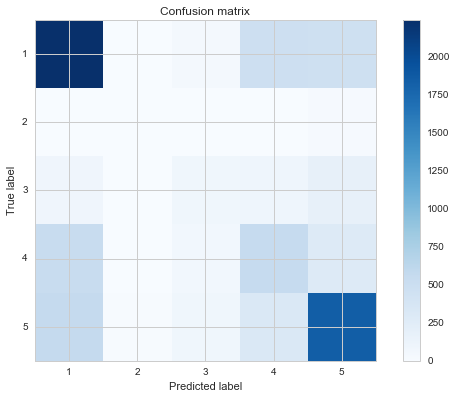

In [80]:
cm = confusion_matrix(validation_data['Target'], output)
print(cm)
plt.figure()
plot_confusion_matrix(cm)

In [81]:
pd.crosstab(output, validation_data['Target'])

Target,1,2,3,4,5
row_0,,,,,
1,2247,8,95,534,567
2,2,5,2,0,16
3,51,7,79,68,83
4,479,4,105,553,316
5,459,25,181,283,1844


In [99]:
training_error = forest.score(X, Y)
validation_error = forest.score(validation_set, validation_data['Target'])
test_error = forest.score(test_set, test_data['Target'])

print "Training error: ", training_error
print "Validation error: ", validation_error
print "Test error: ", test_error

Training error:  0.886933732684
Validation error:  0.590716246569
Test error:  0.57988017973


In [104]:
X = train_data.drop('isBlack',axis=1)
X = X.drop('Target',axis=1)
X = X.drop('Hour', axis=1)
X = X.drop('Month', axis=1)
Y = train_data['Target']
validation_set = validation_data.drop('isBlack', axis=1)
validation_set = validation_set.drop('Hour', axis=1)
validation_set = validation_set.drop('Month', axis=1)

test_set = test_data.drop('isBlack', axis=1)
test_set = test_set.drop('Hour', axis=1)
test_set = test_set.drop('Month', axis=1)
test_set = test_set.drop('Target', axis=1)

In [105]:
clf = forest.fit(X,Y)
validation_set = validation_set.drop('Target', axis=1)
output = forest.predict(validation_set)
pd.crosstab(output, validation_data['Target'])

Target,1,2,3,4,5
row_0,,,,,
1,1276,4,35,331,438
3,3,0,24,17,26
4,163,2,57,272,107
5,177,22,98,96,859


In [106]:
training_error = forest.score(X, Y)
validation_error = forest.score(validation_set, validation_data['Target'])
test_error = forest.score(test_set, test_data['Target'])

print "Training error: ", training_error
print "Validation error: ", validation_error
print "Test error: ", test_error

Training error:  0.62507354121
Validation error:  0.606688295483
Test error:  0.599600599101


In [86]:
X = train_data.drop('Month',axis=1)
X = X.drop('Target',axis=1)
Y = train_data['Target']
validation_set = validation_data.drop('Month', axis=1)
clf = forest.fit(X,Y)
validation_set = validation_set.drop('Target', axis=1)
output = forest.predict(validation_set)
pd.crosstab(output, validation_data['Target'])

Target,1,2,3,4,5
row_0,,,,,
1,2430,5,93,667,707
2,0,4,2,2,7
3,42,5,82,47,73
4,357,5,104,485,272
5,409,30,181,237,1767


In [87]:
training_error = forest.score(X, Y)
validation_error = forest.score(validation_set, validation_data['Target'])

print "Training error: ", training_error
print "Validation error: ", validation_error

Training error:  0.733540140129
Validation error:  0.595033071259


In [88]:
from sklearn import tree

t = tree.DecisionTreeClassifier(max_depth = 8,
                                    criterion = 'entropy', 
                                    class_weight = 'balanced',
                                    random_state = 2)

X = train_data.drop('Target',axis=1)
Y = train_data['Target']
validation_set = validation_data.drop('Target', axis=1)


t.fit(X, Y)

print t.score(X, Y)
print t.score(validation_set, validation_data['Target'])

0.521955393913
0.502683139898


In [89]:
X = train_data.drop('Month',axis=1)
X = X.drop('Target',axis=1)
Y = train_data['Target']
validation_set = validation_data.drop('Month', axis=1)
validation_set = validation_set.drop('Target', axis=1)

t = tree.DecisionTreeClassifier(max_depth = 6,
                                    criterion = 'entropy', 
                                    class_weight = 'balanced',
                                    random_state = 2)

t.fit(X, Y)

print t.score(X, Y)
print t.score(validation_set, validation_data['Target'])

0.435203508584
0.430425558467


In [116]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cross_validation import cross_val_score
clf = AdaBoostClassifier(n_estimators=100)
X = train_data.drop('Target',axis=1)
Y = (train_data['Target'])
clf.fit(X, Y)
validation_set = validation_data.drop(['Target'],axis=1)
scores = cross_val_score(clf, X, Y)

In [117]:
clf.score(validation_set, validation_data['Target'])

0.61118043424007984

In [118]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0).fit(X, Y)
clf.score(validation_set, validation_data['Target'])

0.62790117294734216